In [1]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

# Input Cl's

In [2]:
def read_cl():
    l = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(0))
    l = np.append(np.array([0.0,1.0]), l[:8191])
    cl = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(1))
    cl = np.append(np.array([0.0,0.0]), cl[:8191])
    return l, cl

l , cl = read_cl()

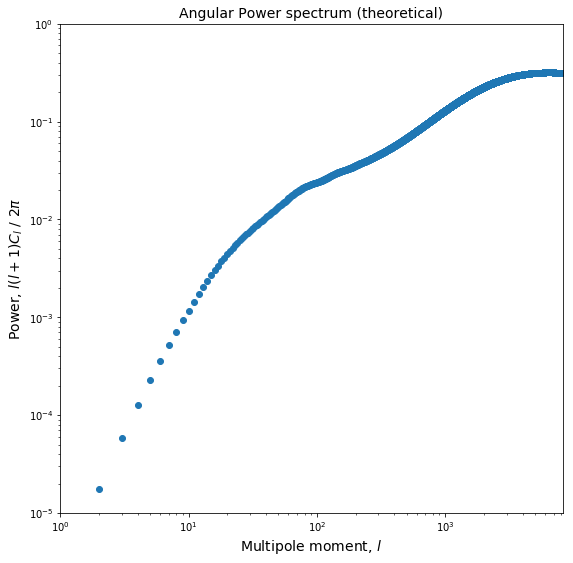

In [3]:
plt.figure(figsize=(9,9))

plt.scatter(l, l*(l+1)*cl/(2*np.pi))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1,8192)
plt.ylim(1e-5,1)
plt.xlabel('Multipole moment, $l$', fontsize=14)
plt.ylabel('Power, $l(l+1)C_l$ / $2π$', fontsize=14)
plt.title('Angular Power spectrum (theoretical)', fontsize=14)
plt.savefig('./simulations_output/plot_output/Angular_power_spectrum_Cl_data.pdf')

# FLASK (for creating lognormal map)

In [4]:
# use the lognormal_map_producer.sh from terminal
# as a first step flask calculates the theoretical angular correlation function and outputs it as a .dat file

theta_flask = np.loadtxt('./simulations_output/lognormal_map/Xi_flask.dat', usecols=(0))
xi_flask = np.loadtxt('./simulations_output/lognormal_map/Xi_flask.dat', usecols=(1)) # xi aka w(theta)

### Check for the value of the angular correlation function (using formula with Legendre polynomials)

In [5]:
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

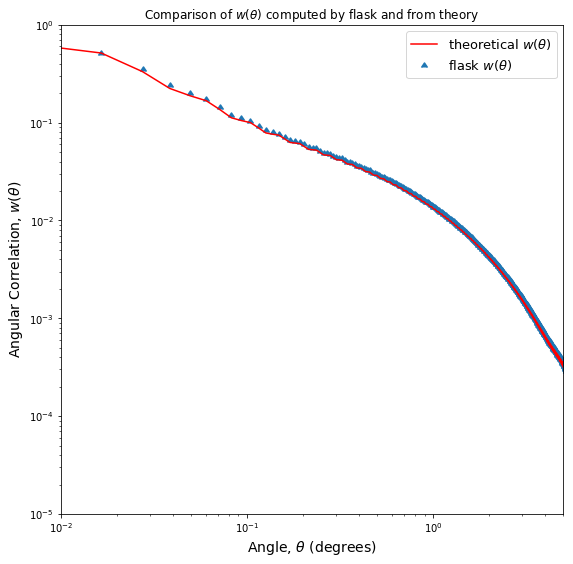

In [6]:
plt.figure(figsize=(9,9))
plt.scatter(theta_flask, xi_flask, marker=10, label='flask $w(θ)$')
plt.plot(theta_flask, w_theta(theta_flask*np.pi/180), c='r', label='theoretical $w(θ)$')
plt.xlim(0.01,5)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (degrees)', fontsize=14)
plt.ylabel('Angular Correlation, $w(θ)$', fontsize=14)
plt.title('Comparison of $w(θ)$ computed by flask and from theory')
plt.legend(fontsize=13)
plt.savefig('./simulations_output/plot_output/flask_and_theoretical_angular_correlation.pdf')

# Reason for the slight discrepancy between the formula (red) and flask (blue) might be due to the fact that for
# l=1, we set cl=0 (for formula computation) whereas flask uses an extrapolated cl value for l=1 which isn't 0

# Flask output: Visualize Lognormal density field in Healpy map

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

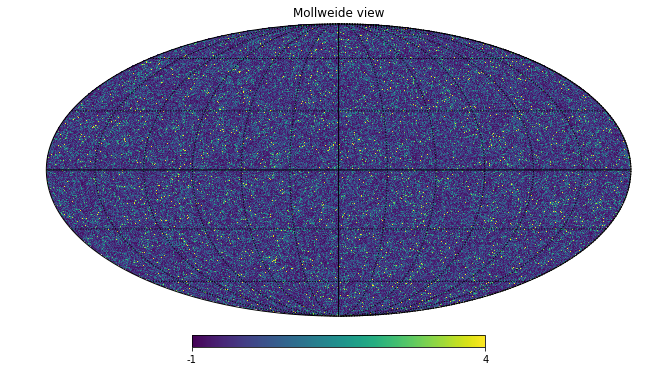

In [7]:
# flask produces the Lognormal density field (using healpy to get Gaussian field and then exponentiating)
# as a healpy fits map

density_field_lognormal = hp.fitsfunc.read_map('./simulations_output/lognormal_map/lognormal_map.fits')

nside = 4096

plt.figure(figsize=(12,12))
hp.mollview(density_field_lognormal, min=-1, max=4)
hp.graticule()
plt.savefig('./simulations_output/plot_output/density_field_lognormal_map.pdf')

# Make patches of pixels and save with astropy (fits) for feeding into treecorr

### Patch 1

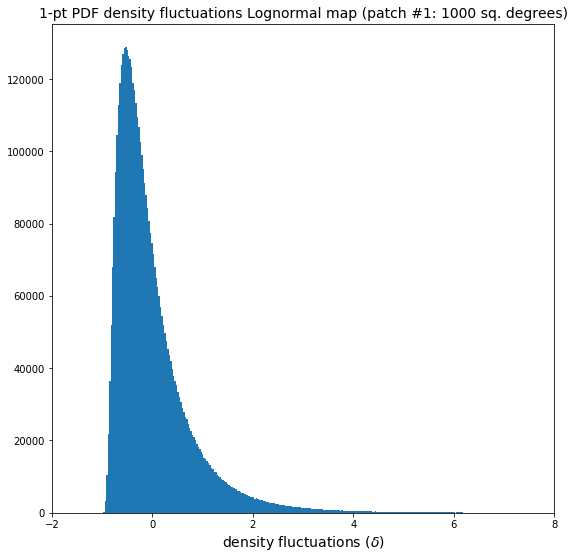

In [8]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 101010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_1.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #1: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_1.pdf")

### Patch 2

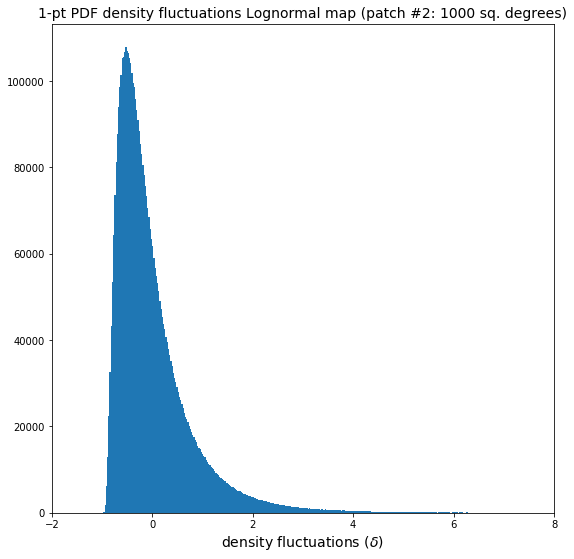

In [9]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 131010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_2.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #2: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_2.pdf")

### Patch 3

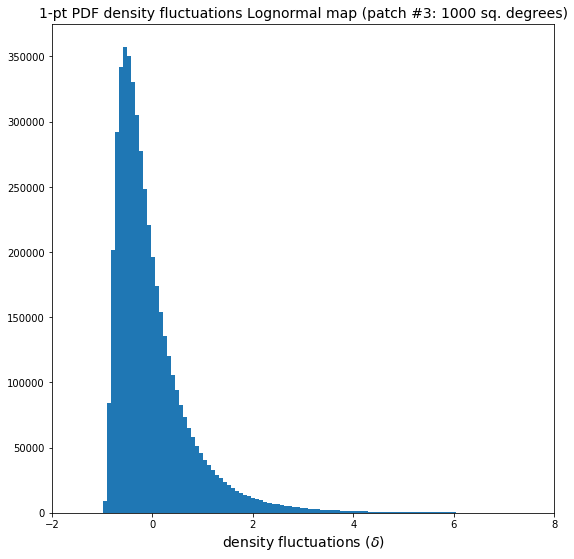

In [10]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 151010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_3.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #3: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_3.pdf")

### Patch 4

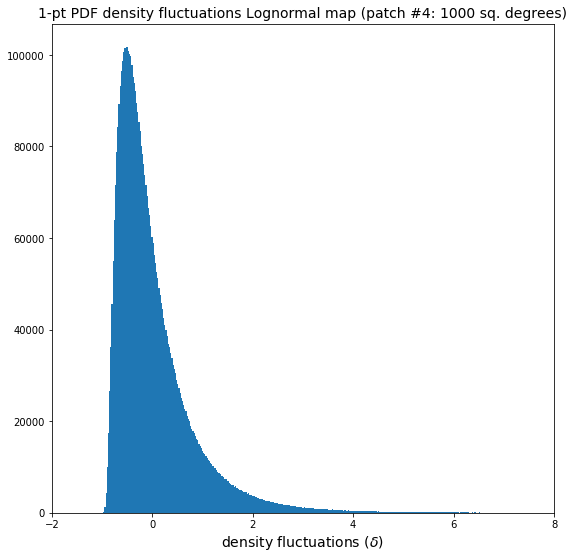

In [11]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 171010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_4.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #4: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_4.pdf")

### Patch 5

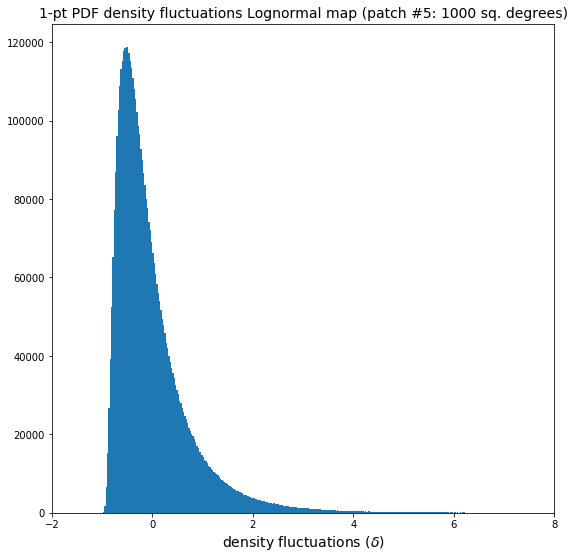

In [12]:
# Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 191010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_5.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #5: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_5.pdf")

### Patch 6

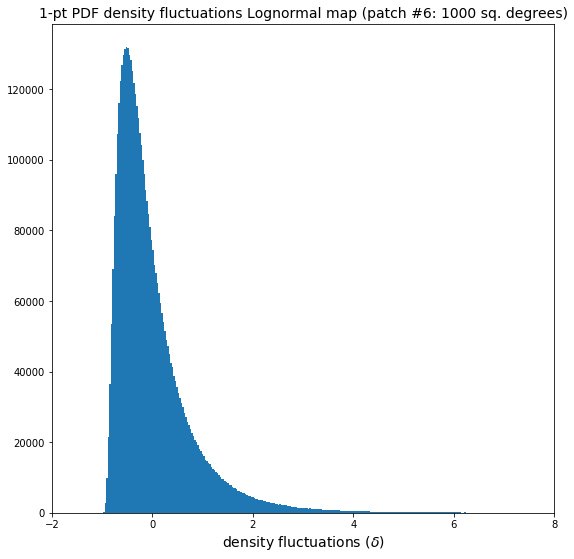

In [13]:
# # Choose a random pixel i.e. center of disc (patch on the sky map) around which to take 1000 deg square area
disc_center = hp.pix2vec(nside, 51010101)

# radius (in radians) corresponding to 1000 deg square patch in sky = 0.31 radians

# find the pixels 
pixels_indices_disc = hp.query_disc(nside, disc_center, 0.31)

density_field_lognormal_disc = density_field_lognormal[pixels_indices_disc]
dec = np.pi/2 - hp.pix2ang(nside, pixels_indices_disc)[0]
RA = hp.pix2ang(nside, pixels_indices_disc)[1]

# for saving into fits file with astropy
RA_data = Column(RA, name='RA', dtype='float') # column having ra
dec_data = Column(dec, name='dec', dtype='float') # column having dec
del_g_data = Column(density_field_lognormal_disc, name='del_g', dtype='float') # column having pixels_disc_values

density_fluctuations_table = Table((RA_data, dec_data, del_g_data))  
# density_fluctuations_table.show_in_notebook()

density_fluctuations_table.write("./simulations_output/different_patches/density_fluctuations_lognormal_patch_6.fits" , overwrite=True)

# 1-pt PDF of density fluctuations within patch

plt.figure(figsize=(9,9))
plt.hist(density_field_lognormal_disc, bins=1000)
plt.xlabel('density fluctuations ($δ$)', fontsize=14)
plt.xlim(-2,8)
plt.title('1-pt PDF density fluctuations Lognormal map (patch #6: 1000 sq. degrees)', fontsize=14)
plt.savefig("./simulations_output/plot_output/1_pt_PDF_different_patches/density_fluctuations_lognormal_1_pt_PDF_patch_6.pdf")

# TreeCorr: for auto-correlation of the lognormal density fluctuations

### Patch 1

In [16]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_1.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_1.txt', dat, delimiter = ' ')

### Patch 2

In [17]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_2.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_2.txt', dat, delimiter = ' ')

### Patch 3

In [18]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_3.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_3.txt', dat, delimiter = ' ')

### Patch 4

In [19]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_4.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_4.txt', dat, delimiter = ' ')

### Patch 5

In [20]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_5.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_5.txt', dat, delimiter = ' ')

### Patch 6

In [21]:
density_fluctuations = hp.read_cl('./simulations_output/different_patches/density_fluctuations_lognormal_patch_6.fits')

density_fluctuations_RA = density_fluctuations[0,:]
density_fluctuations_dec = density_fluctuations[1,:]
density_fluctuations_del_g = density_fluctuations[2,:]

cat = treecorr.Catalog(ra=density_fluctuations_RA, dec=density_fluctuations_dec,
                        ra_units='rad', dec_units='rad', k=density_fluctuations_del_g)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=300, nbins=20, sep_units='arcmin')
kk.process(cat) 
theta_tc = kk.meanr
xi_tc = kk.xi

dat = np.array([theta_tc, xi_tc])
dat = dat.T
np.savetxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_6.txt', dat, delimiter = ' ')

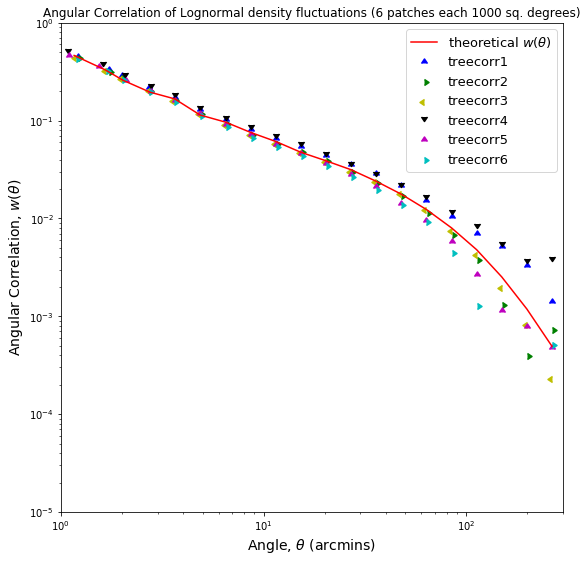

In [14]:
theta_treecorr1 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_1.txt', usecols=(0)) # in arcmins
xi_treecorr1 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_1.txt', usecols=(1)) # xi aka w(theta)

theta_treecorr2 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_2.txt', usecols=(0)) # in arcmins
xi_treecorr2 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_2.txt', usecols=(1)) # xi aka w(theta)

theta_treecorr3 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_3.txt', usecols=(0)) # in arcmins
xi_treecorr3 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_3.txt', usecols=(1)) # xi aka w(theta)

theta_treecorr4 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_4.txt', usecols=(0)) # in arcmins
xi_treecorr4 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_4.txt', usecols=(1)) # xi aka w(theta)

theta_treecorr5 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_5.txt', usecols=(0)) # in arcmins
xi_treecorr5 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_5.txt', usecols=(1)) # xi aka w(theta)

theta_treecorr6 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_6.txt', usecols=(0)) # in arcmins
xi_treecorr6 = np.loadtxt('./simulations_output/different_patches/treecorr_angular_correlation_lognormal_patch_6.txt', usecols=(1)) # xi aka w(theta)

theta_theoretical = (theta_treecorr1+theta_treecorr2+theta_treecorr3+
                     theta_treecorr4+theta_treecorr5+theta_treecorr6) / 6

plt.figure(figsize=(9,9))
plt.scatter(theta_treecorr1,xi_treecorr1, c='b', marker=10, label='treecorr1')
plt.scatter(theta_treecorr2,xi_treecorr2, c='g', marker=9, label='treecorr2')
plt.scatter(theta_treecorr3,xi_treecorr3, c='y', marker=8, label='treecorr3')
plt.scatter(theta_treecorr4,xi_treecorr4, c='k', marker=7, label='treecorr4')
plt.scatter(theta_treecorr5,xi_treecorr5, c='m', marker=10, label='treecorr5')
plt.scatter(theta_treecorr6,xi_treecorr6, c='c', marker=9, label='treecorr6')
plt.plot(theta_theoretical, w_theta(theta_theoretical/60*np.pi/180), c='r', label='theoretical $w(θ)$')
plt.xlim(1,300)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle, $θ$ (arcmins)', fontsize=14)
plt.ylabel('Angular Correlation, $w(θ)$', fontsize=14)
plt.title('Angular Correlation of Lognormal density fluctuations (6 patches each 1000 sq. degrees)')
plt.legend(loc='best', fontsize=13)
plt.savefig('./simulations_output/plot_output/treecorr_and_theoretical_angular_correlation_lognormal_different_patches.pdf')

# We can see the (cosmic variance) in the large scales i.e. small l --> more uncertainty (see Dodelson)